# Identify performance profiles of F1 drivers using Kmeans clustering

1. Import data

2. Build model (with hyperparameter tuning)

3. Label Cluster

4. Visualize Clusters

## Step 1. Import data

In [1]:
# %pip install kneed
# %pip install -U jupysql duckdb-engine
# %pip install kagglehub[pandas-datasets]

In [2]:
# Load packages
import kagglehub
import pandas as pd
import duckdb as ddb
import os
import numpy as np
import random

# Set seeds
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Replace with your actual database connection
conn = ddb.connect() 

# Download data from kaggle
path = kagglehub.dataset_download("rohanrao/formula-1-world-championship-1950-2020")

# Load each CSV into a DataFrame
tables = []
for f in os.listdir(path):
    if f.endswith('.csv'):
        table_name = f.replace('.csv', '')
        file_path = os.path.join(path, f)
        tables.append(table_name)
        globals()[table_name] = pd.read_csv(file_path, na_values = ['\\N', 'NA', 'null', '?'])

# Get dataset with SQL query
with open("query.sql", "r") as f:
    query = f.read()

df = conn.execute(query).df()

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Missing values in columns
missing_counts = df.isna().sum()
missing_counts[missing_counts > 0]

Series([], dtype: int64)

In [4]:
df

,driverId,driver_name,races_count,avg_finish_position,avg_qualifying_position,avg_points,avg_position_delta,out_qualify_percent,out_perform_percent,no_result_percent
0,1,Lewis Hamilton,356,3.644172,4.073034,13.540730,0.963483,0.617978,0.606232,0.084270
1,2,Nick Heidfeld,99,7.746988,9.858586,2.292929,3.252525,0.444444,0.521277,0.161616
2,3,Nico Rosberg,206,6.355932,6.834951,7.740291,1.441748,0.606796,0.556122,0.140777
3,4,Fernando Alonso,352,6.420000,8.173295,6.275568,2.627841,0.747159,0.705015,0.147727
4,5,Heikki Kovalainen,112,11.835165,13.883929,0.937500,4.125000,0.500000,0.523810,0.187500
...,...,...,...,...,...,...,...,...,...,...
92,857,Oscar Piastri,46,7.116279,7.543478,7.543478,0.782609,0.239130,0.282609,0.065217
93,858,Logan Sargeant,36,15.689655,17.388889,0.027778,3.750000,0.000000,0.147059,0.194444
94,859,Liam Lawson,11,12.909091,13.363636,0.545455,0.545455,0.090909,0.545455,0.000000
95,860,Oliver Bearman,3,9.666667,13.000000,2.333333,2.333333,0.666667,0.666667,0.000000


## Step 2. Fit Model 

- Determine best number of clusters using Inertia & Silhouette Score

- Refit model using optimal number of clusters

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from kneed import KneeLocator


X = df.drop(columns=["driverId", "driver_name"])

# Standardize the features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  Set up to choose optimal number of clusters
inertia = []
silhouette_scores = []

k_range = range(2, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init = 20, random_state=SEED)
    model = kmeans.fit(X_scaled)
    labels = kmeans.predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

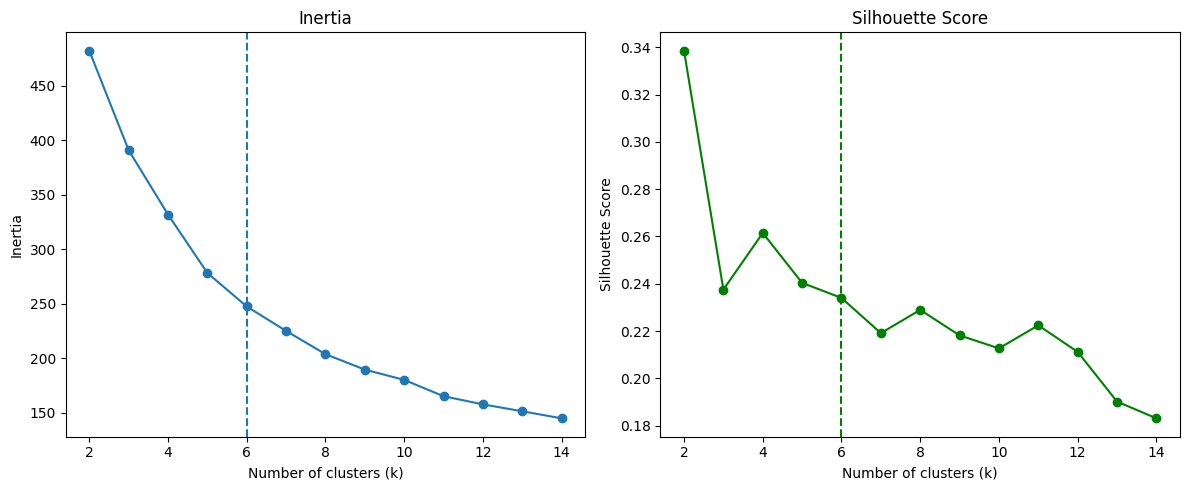

In [6]:
# Get optimal number of clusters from elbow
elbow_point = KneeLocator(k_range, inertia, curve="convex", direction="decreasing").elbow

# Plot Inertia
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.axvline(x=elbow_point, linestyle='--')
plt.title('Inertia')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')


# Plot Silhouette scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.axvline(x=elbow_point, color='green', linestyle='--')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [7]:
optimal_k = elbow_point
kmeans_final = KMeans(n_clusters=optimal_k, n_init = 20, random_state=SEED)
kmeans_final.fit(X_scaled)
labels = kmeans_final.labels_
df["clusters"] = labels.astype(str)

In [8]:
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.manifold import TSNE

# PCA 
pca = PCA(n_components=3, random_state=SEED)
X_pca = pca.fit_transform(X_scaled)

# Add the components and cluster label to dataframe
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]
df['PCA3'] = X_pca[:, 2]

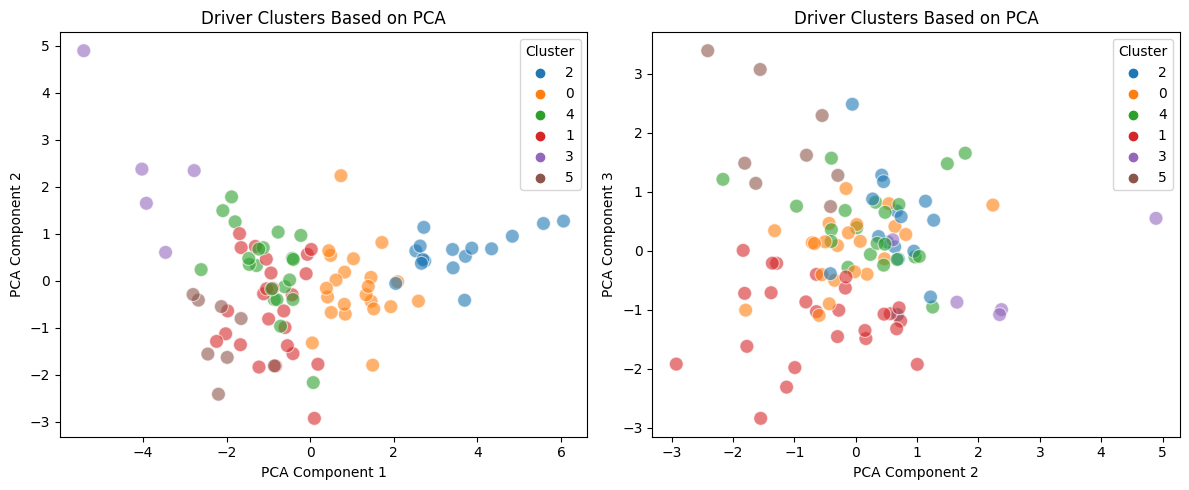

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot
plt.figure(figsize=(12, 5))

    # Plot PCA clusters
plt.subplot(1, 2, 1)
plt.title("Driver Clusters Based on PCA")
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='clusters', alpha=0.6, s=100)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')

plt.subplot(1, 2, 2)
plt.title("Driver Clusters Based on PCA")
sns.scatterplot(data=df, x='PCA2', y='PCA3', hue='clusters', alpha=0.6, s=100)
plt.xlabel("PCA Component 2")
plt.ylabel("PCA Component 3")
plt.legend(title='Cluster')


plt.tight_layout()
plt.show()

## Step 3. Interpret and Label Clusters

In [10]:
# Aggregate summary statistics by each cluster
cluster_summaries = df.groupby("clusters")[X.columns].agg(['mean', 'std']).round(2)
cluster_summaries[('N', '')] = df.groupby("clusters").size()

# move 'N' col to front and print
cols = [('N', '')] + [col for col in cluster_summaries.columns if col != ('N', '')]
cluster_summaries = cluster_summaries[cols]
cluster_summaries

N races_count        avg_finish_position        \
                    mean    std                mean   std   
clusters                                                    
0         22      111.50  53.82                9.97  1.99   
1         25       43.52  30.42               14.62  1.75   
2         16      227.88  81.08                6.48  1.45   
3          5       12.40   7.40               15.82  2.03   
4         21       39.57  22.86               12.22  1.70   
5          8       22.62  20.37               16.60  1.38   

         avg_qualifying_position       avg_points       avg_position_delta  \
                            mean   std       mean   std               mean   
clusters                                                                     
0                          11.51  1.74       2.13  1.09               2.96   
1                          17.88  2.11       0.29  0.41               5.93   
2                           7.42  1.64       7.60  2.83               1.81   
3                          21.01  1.76       0.05  0.12              12.96   
4                          14.90  1.83       0.49  0.33               5.60   
5                          18.95  1.43       0.04  0.08               3.63   

               out_qualify_percent       out_perform_percent        \
           std                mean   std                mean   std   
clusters                                                             
0         0.89                0.50  0.13                0.48  0.08   
1         1.84                0.50  0.14                0.54  0.11   
2         0.75                0.54  0.15                0.53  0.12   
3         2.82                0.19  0.21                0.27  0.17   
4         1.86                0.25  0.13                0.40  0.10   
5         2.09                0.12  0.15                0.16  0.12   

         no_result_percent        
                      mean   std  
clusters                          
0                     0.18  0.08  
1                     0.22  0.10  
2                     0.13  0.04  
3                     0.53  0.15  
4                     0.26  0.10  
5                     0.13  0.11

Baseline characteristics

In [11]:
df[X.columns].agg(['mean', 'std']).round(2)

,races_count,avg_finish_position,avg_qualifying_position,avg_points,avg_position_delta,out_qualify_percent,out_perform_percent,no_result_percent
mean,85.16,11.93,14.31,1.93,4.68,0.41,0.45,0.21
std,84.23,3.63,4.52,2.93,2.96,0.20,0.16,0.12


In [12]:
# df[df['clusters'] ==4][['driver_name', 'races_count', 'avg_qualifying_position', 'avg_finish_position', 'avg_position_delta', 'out_qualify_percent', 'no_result_percent']]

Cluster interpretations

**Cluster 0**: Above Average Veterans (n=22)
- High races count (mean (sd) = 111.5(53.82))
- Better performance than teammate (Outperform and out-qualify rates ~50%)
- Able to earn points (mean (sd) = 2.96 (0.89))
- Low no result rate 


**Cluster 1**: Underdogs (n=25)
- Low race counts (\<100)
- Better performance than teammate (Outperform and out-qualify rates ~50%)
- Improve during race (finish ranking is higher than qualifying)


**Cluster 2**: Top Performers (n=16)
- Earns points for the team
- Better performance than teammate (Outperform and out-qualify rates ~50%)
- Finishes more than 85% of races races


**Cluster 3**: Worst performers (n=5)
- Low race count
- Frqequently fail to finish the race or finish near the back
- looses many positions in races


**Cluster 4**: Mediocre drivers (n=21)
- Low race counts
- Mediocre finish and qualifying
- Low avg points


**Cluster 5**: Passive Drivers (n=8)
- Low race count
- Low aggression: rarely have null result or gain positions
- Don't score points, but stay clean


In [13]:
# Assuming you have already assigned clusters to the drivers
cluster_labels = {
    '0': 'Above Average Veterans',    
    '1': 'Underdogs',
    '2': 'Top Drivers',
    '3': 'Worst Drivers',
    '4': 'Mediocre Drivers', 
    '5': 'Passive Drivers'
}

label_order = [
    "Top Drivers",
    "Above Average Veterans",
    "Underdogs",
    "Mediocre Drivers",
    "Passive Drivers",
    "Worst Drivers"
]

df['cluster_label'] = pd.Categorical(df['clusters'].map(cluster_labels), categories=label_order, ordered=True)

## Step 4. Visualize Clusters

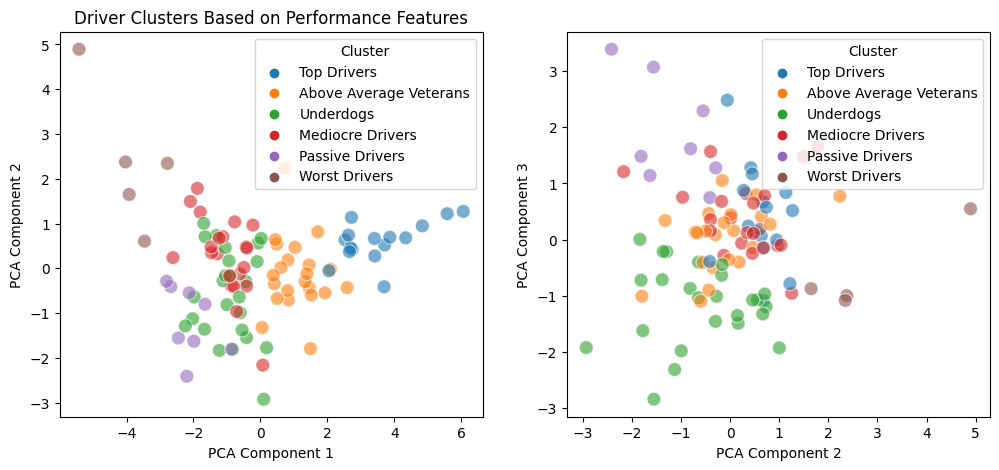

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the clusters
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Driver Clusters Based on Performance Features")
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='cluster_label', alpha=0.6, s=100)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='PCA2', y='PCA3', hue='cluster_label', alpha=0.6, s=100)
plt.xlabel("PCA Component 2")
plt.ylabel("PCA Component 3")
plt.legend(title='Cluster')

plt.show()

## Conclusion

Using Kmeans clustering, we catagorized drivers into 6 categories : Top Performers, Above Average Veterans, Underdogs, Mediocre Drivers, Passive Drivers, and Worst Drivers. 

<br><br>

For the drivers that are in the the Netflix servies "Drive to Survive" (F1 Season 2018-2024): 

In [15]:
driver_names = conn.execute("""SELECT DISTINCT d.forename || ' ' || d.surname AS driver_name FROM drivers d LEFT JOIN results r ON d.driverId = r.driverId LEFT JOIN races ON r.raceId = races.raceId WHERE races.year >= 2018""").df()["driver_name"].to_numpy()
driver_names

array(['Lewis Hamilton', 'Stoffel Vandoorne', 'Carlos Sainz',
       'Oliver Bearman', 'Sebastian Vettel', 'Nico Hülkenberg',
       'Brendon Hartley', 'Franco Colapinto', 'Liam Lawson',
       'Daniel Ricciardo', 'Lance Stroll', 'Lando Norris', 'Yuki Tsunoda',
       'Charles Leclerc', 'Robert Kubica', 'Pietro Fittipaldi',
       'Nyck de Vries', 'Fernando Alonso', 'Valtteri Bottas',
       'Sergio Pérez', 'Nicholas Latifi', 'Nikita Mazepin',
       'Pierre Gasly', 'Esteban Ocon', 'Kimi Räikkönen',
       'Kevin Magnussen', 'Marcus Ericsson', 'George Russell',
       'Jack Aitken', 'Mick Schumacher', 'Logan Sargeant', 'Jack Doohan',
       'Alexander Albon', 'Guanyu Zhou', 'Oscar Piastri',
       'Romain Grosjean', 'Max Verstappen', 'Sergey Sirotkin',
       'Daniil Kvyat', 'Antonio Giovinazzi'], dtype=object)

In [18]:
df_subset = df[df['driver_name'].isin(driver_names)]
for label in label_order:
    drivers_in_cluster = df_subset[df_subset['cluster_label'] == label]
    print(f"\n Label: {label}")
    print("- Drivers:", drivers_in_cluster['driver_name'].tolist())


 Label: Top Drivers
- Drivers: ['Lewis Hamilton', 'Fernando Alonso', 'Kimi Räikkönen', 'Sebastian Vettel', 'Sergio Pérez', 'Daniel Ricciardo', 'Valtteri Bottas', 'Max Verstappen', 'Carlos Sainz', 'Charles Leclerc', 'Lando Norris', 'Oscar Piastri']

 Label: Above Average Veterans
- Drivers: ['Robert Kubica', 'Romain Grosjean', 'Nico Hülkenberg', 'Kevin Magnussen', 'Daniil Kvyat', 'Esteban Ocon', 'Lance Stroll', 'Antonio Giovinazzi', 'Pierre Gasly', 'George Russell', 'Alexander Albon', 'Yuki Tsunoda', 'Oliver Bearman']

 Label: Underdogs
- Drivers: ['Marcus Ericsson', 'Sergey Sirotkin', 'Mick Schumacher']

 Label: Mediocre Drivers
- Drivers: ['Stoffel Vandoorne', 'Brendon Hartley', 'Guanyu Zhou', 'Liam Lawson', 'Franco Colapinto']

 Label: Passive Drivers
- Drivers: ['Nicholas Latifi', 'Pietro Fittipaldi', 'Nikita Mazepin', 'Nyck de Vries', 'Logan Sargeant']

 Label: Worst Drivers
- Drivers: []
